<a href="https://colab.research.google.com/github/jpmachinelearning/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J/blob/main/src/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# ==========================================
# 1. INSTALACION DE LIBRERIAS
# ==========================================

!pip install PyGithub
!python -m spacy download es_core_news_lg
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 3.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 4.8 MB/s eta 0:00:00


In [53]:

# ================================================
# 2. IMPORTACIÓN DE LIBRERIAS Y VARIABLES GLOBALES
# ================================================

import emoji
import re
import spacy
import nltk
import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
from google.colab import files, userdata
from github import Github, Auth, GithubException
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

# Descargas NLTK (ejecutar una vez)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')
nltk.download('stopwords', quiet=True)

STOP_ES = set(stopwords.words('spanish'))
STOP_EN = set(stopwords.words('english'))

nlp = spacy.blank("es")
nlp2 = spacy.load("es_core_news_lg")

if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")

INLINE_CODE = re.compile(r'`[^`]+`')
FENCED_CODE = re.compile(r'```(.+?)```', re.DOTALL)
CODE_KEYWORDS = re.compile(r'\b(def|class|import|from|return|console\.log|printf|#include|std::|->|=>)\b')
BRACES_SEMICOLON = re.compile(r'[{};=<>]')
IMG_TAG = re.compile(r'<img\b[^>]*>', re.IGNORECASE)
HTML_TAG = re.compile(r'<\/?\w+[^>]*>', re.IGNORECASE)
URL_LARGE = re.compile(r'https?://\S{30,}', re.IGNORECASE)
ASSET_DOMAINS = re.compile(r'(github\.com|githubusercontent\.com|assets/|cdn\.)', re.IGNORECASE)

MAPEO_LEMAS = {
  "hi": "hola",
  "Ademas": "además",
  "ademas": "además",
  "qutarir": "quitar",
  "qutacer": "quitar",
  "qutaria": "quitar",
  "qutaría": "quitar",
  "añadiais": "añadir",
  "válir": "válido",
  "Gracia": "gracias",
  "gracia": "gracias",
  "modul": "módulo",
  "finar": "final",
  "somar": "sumar",
  "deveria": "deber",
  "devería": "deber",
  "estaria": "estar",
  "estáría": "estar",
  "configurancion": "configuración",
  "temrinos": "términos",
  "despés": "después",
  "propois": "propios",
  "válir": "valer",
  "viudedad": "viudedad",
  "reav": "revisar",
  "qeu": "que",
  "pusistar": "pusiste",
  "modificaco": "modificado",
  "descárgatar": "descargar",
  "fuentir": "fuente",
  "invoizar": "facturar",
  "informacion": "información",
  "subsana": "subsanar",
  "eskema": "esquema",
  }

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [20]:

# ===============================================
# 3. CONEXIÓN Y CLONADO DE REPOSITORIO DE GITHUB
# ===============================================

try:
    TOKEN = userdata.get('GITHUB_TOKEN')
    USER_GITHUB = "jpmachinelearning"
    EMAIL_GITHUB = userdata.get('MY_EMAIL')

    # Configurar identidad global de Git de una vez
    !git config --global user.email "{EMAIL_GITHUB}"
    !git config --global user.name "{USER_GITHUB}"
except userdata.SecretNotFoundError:
    print("❌ Error: Crea el secreto 'GITHUB_TOKEN' en el panel lateral.")

# --- RUTAS Y NOMBRES ---
DEST_REPO_NAME = 'U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J'
REPO_URL = f"https://{TOKEN}@github.com/{USER_GITHUB}/{DEST_REPO_NAME}.git"
ruta_repositorio_local = f"/content/{DEST_REPO_NAME}"
ruta_local_data = os.path.join(ruta_repositorio_local, 'data')


# --- FUNCIÓN DE UTILIDAD PARA CLONADO/SINCRO ---
def inicializar_repositorio():
    %cd /content/
    if not os.path.exists(DEST_REPO_NAME):
        print(f"🚀 Clonando {DEST_REPO_NAME}...")
        !git clone {REPO_URL}
    else:
        print(f"🔄 Sincronizando repositorio...")
        %cd {DEST_REPO_NAME}
        !git pull origin main
        %cd /content/
    os.makedirs(os.path.dirname(ruta_local_data), exist_ok=True)
    print(f"📂 Carpeta de datos lista en: {os.path.dirname(ruta_local_data)}")
# Inicializar carpeta si no existe
inicializar_repositorio()


/content
🔄 Sincronizando repositorio...
/content/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J
From https://github.com/jpmachinelearning/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J
 * branch            main       -> FETCH_HEAD
Already up to date.
/content
📂 Carpeta de datos lista en: /content/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J


In [22]:

# ==========================================
# 4. FUNCIONES
# ==========================================

### ---  Funciones de para prepeocesado ---
def ensure_text_input(corpus):
    if isinstance(corpus, str):
        return corpus
    # pandas Series o DataFrame cell
    if pd is not None and isinstance(corpus, pd.Series):
        # eliminar NaN y convertir a str
        parts = [str(x) for x in corpus.dropna().astype(str).tolist()]
        return "\n\n".join(parts)
    # lista/tupla de strings
    if isinstance(corpus, (list, tuple)):
        parts = [str(x) for x in corpus if x is not None]
        return "\n\n".join(parts)
    # fallback: intentar str()
    return str(corpus)

def apply_mapeo_and_simple_grammar(text, corrections=None):
    """
    Aplica MAPEO_LEMAS sobre tokens y corrige patrones gramaticales puntuales.
    Si se pasa 'corrections' (lista), añade tuplas (original, reemplazo).
    """
    if not isinstance(text, str) or not text:
        return text
    # Normalizar tokens simples usando MAPEO_LEMAS (mantener espacios)
    def replace_token_match(m):
        tok_orig = m.group(0)
        tok = tok_orig.lower()
        tok_repl = MAPEO_LEMAS.get(tok, tok)
        # registrar si hubo cambio real y se pasó lista
        if corrections is not None and tok_repl != tok:
            corrections.append((tok_orig, tok_repl))
        return tok_repl
    pattern = re.compile(r'\b(' + '|'.join(re.escape(k) for k in MAPEO_LEMAS.keys()) + r')\b', flags=re.IGNORECASE)
    text = pattern.sub(lambda m: replace_token_match(m), text)
    # Reglas gramaticales puntuales
    def replace_ningun_excepcion(m):
        orig = m.group(0)
        repl = 'ninguna excepción'
        if corrections is not None:
            corrections.append((orig, repl))
        return repl
    text = re.sub(r'\bningún\s+excepción\b', replace_ningun_excepcion, text, flags=re.IGNORECASE)
    # corregir dobles espacios
    text = re.sub(r'\s{2,}', ' ', text)
    text = text.strip()
    return text

# --- Sustituciones finales robustas: URLs -> 'url' y números -> 'num' ---
def apply_placeholders_preserve_punct(text: str, replacements=None) -> str:
    if not isinstance(text, str) or not text:
        return text
    # URL pattern (prioriza detección de URL completa)
    url_pattern = re.compile(r'(?P<prefix>[\(\[\{<"\']?)'r'(?P<url>(?:https?[:/]{0,3}|//|www\.)'r'[A-Za-z0-9\-]+'r'(?:\.[A-Za-z0-9\-]+)+'r'(?:[\/?#][^\s\)\]\}\>,.;:!?"\']*)?)'r'(?P<suffix>[\)\]\}>,.;:!?"\']*)',flags=re.IGNORECASE)
    def _url_sub(m):
        orig = m.group('url')
        if replacements is not None:
            replacements.append((orig, 'url'))
        return f"{m.group('prefix')} {m.group('suffix')}"
    text = url_pattern.sub(_url_sub, text)
    # Número puro: preservar prefijo/sufijo de puntuación
    number_pattern = re.compile(r'(?<![A-Za-z0-9])'r'(?P<prefix>[\(\[\{<"\']?)'r'(?P<num>\d+)'r'(?P<suffix>[\)\]\}>,.;:!?"\']?)'r'(?![A-Za-z0-9])')
    def _num_sub(m):
        orig = m.group('num')
        if replacements is not None:
            replacements.append((orig, 'num'))
        return f"{m.group('prefix')} {m.group('suffix')}"
    text = number_pattern.sub(_num_sub, text)
    return text

def preprocesado(doc):
  # Pipeline del prepocesado: normalización -> traducción de emoji -> clasificador (doble revisión 'und') / eliminación segmentos 'en', 'und' y 'code' ->
  # elimanción de typos -> cambio de numeros por placeholder 'num' y sitio web por 'url' ->
  # eliminación signos de puntuación -> tokenización -> eliminación de stopwords -> lematización

  ### Normalización
  #Normalizar entrada a texto (maneja None, NaN, Series, listas, etc.)
  doc = ensure_text_input(doc) # Si queda vacío, devolver resultado vacío y log mínimo
  if not doc or str(doc).strip() == "":
    return "", [["input_empty"]]
  doc = doc.lower()

  ### Traducción de emoji
  # Comprobamos si existen emojis en el documento mediante un condicional
  if emoji.emoji_count(doc) > 0:

      # Definimos una función interna (callback) que solo procesa el emoji hallado
      def procesar_emoji_individual(chars, data_dict):
          # Traducimos el emoji a su nombre en español (ej: :cara_sonriente:)
          nombre_emoji = emoji.demojize(chars, language='es')
          # Limpiamos los signos SOLO del nombre generado por demojize.
          # Esto permite que "cara_sonriente" pase a ser "cara sonriente"
          # para que el análisis de sentimiento/TF-IDF lo entienda mejor,
          # pero sin afectar a las URLs del resto del documento.
          nombre_limpio = nombre_emoji.replace(':', '').replace('_', ' ')
          # Devolvemos el texto con espacios para que no se pegue a otras palabras
          return f" {nombre_limpio} "

      # Aplicamos el reemplazo selectivo
      doc = emoji.replace_emoji(doc, replace=procesar_emoji_individual)

  ### Elimanción de typos
  ortho_corrections = []
  doc = apply_mapeo_and_simple_grammar(doc, corrections=ortho_corrections)

  ### Clasificador (doble revision 'und') / eliminacion segmentos 'en', 'und' y 'code'
  def looks_like_code_line(line):
      if INLINE_CODE.search(line):
          return True
      if FENCED_CODE.search(line):
          return True
      if IMG_TAG.search(line) or HTML_TAG.search(line):
          return True
      if URL_LARGE.search(line) and ASSET_DOMAINS.search(line):
          return True
      if CODE_KEYWORDS.search(line):
          return True
      non_alpha = sum(1 for ch in line if not ch.isalpha() and not ch.isspace())
      if len(line) > 0 and (non_alpha / len(line)) > 0.25:
          return True
      if BRACES_SEMICOLON.search(line):
          return True
      return False

  def split_by_blank_and_guess(segment):
      parts = []
      groups = re.split(r'\n\s*\n', segment)
      for g in groups:
          lines = [ln for ln in g.splitlines() if ln.strip() != ""]
          if not lines:
              continue
          # FORZAR code si hay etiquetas img/html o URLs de assets en las líneas
          # (requiere que IMG_TAG, HTML_TAG, URL_LARGE, ASSET_DOMAINS estén definidos globalmente)
          if any(IMG_TAG.search(ln) or (URL_LARGE.search(ln) and ASSET_DOMAINS.search(ln)) or HTML_TAG.search(ln) for ln in lines):
              parts.append(('code', "\n".join(lines)))
              continue
          code_like_count = sum(1 for ln in lines if looks_like_code_line(ln) or ln.startswith('    ') or ln.startswith('\t'))
          prop = code_like_count / len(lines)
          if prop >= 0.4:
              code_lines = []
              text_lines = []
              for ln in lines:
                  tokens = [t.lower() for t in word_tokenize(ln) if t.isalpha()]
                  if len(tokens) >= 2:
                      es_count = sum(1 for t in tokens if t in STOP_ES)
                      if es_count / len(tokens) >= 0.25 or re.search(r'[áéíóúñÁÉÍÓÚÑ]', ln):
                          text_lines.append(ln)
                          continue
                  code_lines.append(ln)
              if code_lines:
                  parts.append(('code', "\n".join(code_lines)))
              if text_lines:
                  parts.append(('text', "\n".join(text_lines)))
          else:
              parts.append(('text', "\n".join(lines)))
      return parts

  def split_into_blocks_by_indentation_and_fences(corpus):
      """
      Acepta corpus de cualquier tipo; primero normaliza a string.
      Extrae fenced code y agrupa el resto por bloques separados por línea en blanco.
      """
      text = ensure_text_input(corpus)
      # --- NORMALIZACIÓN ADICIONAL: convertir separadores en "punto y aparte" ---
      # [sep] o [ sep] -> punto y salto de línea doble
      text = re.sub(r'\[\s*sep\s*\]', '.\n\n', text, flags=re.IGNORECASE)
      # punto seguido (". ") -> punto y salto de línea doble
      text = re.sub(r'\.\s+', '.\n\n', text)
      # ------------------------------------------------------------------------
      blocks = []
      cursor = 0
      for m in FENCED_CODE.finditer(text):
          pre = text[cursor:m.start()]
          if pre.strip():
              blocks.extend(split_by_blank_and_guess(pre))
          code_block = m.group(0)
          blocks.append(('code', code_block))
          cursor = m.end()
      tail = text[cursor:]
      if tail.strip():
          blocks.extend(split_by_blank_and_guess(tail))
      return blocks

  def detect_language_by_stopwords(text, min_tokens=1):
      """
      Detecta 'es', 'en', 'bilingual' o 'und'.
      Ajustes:
        - tokenización robusta (quita prefijos/sufijos no alfabéticos)
        - lista blanca ampliada (incluye 'finde')
        - heurística para frases cortas sin stopwords
        - filtra tokens de longitud 1 al contar stopwords
        - prioriza 'es' cuando la señal española es claramente mayor
        - condición 'bilingual' más estricta
      """
      txt_stripped = text.strip()
      # caso puntual muy corto (ej. "Gracias" o "Gracias.")
      if txt_stripped.lower() in {'gracias', 'gracias.'}:
          return 'es'
      # tokenización robusta: limpiar prefijos/sufijos no alfabéticos
      raw_tokens = word_tokenize(text)
      tokens = []
      for t in raw_tokens:
          t_clean = re.sub(r'^[^A-Za-zÁÉÍÓÚÑáéíóúñ]+|[^A-Za-zÁÉÍÓÚÑáéíóúñ]+$', '', t)
          if t_clean:
              tokens.append(t_clean.lower())
      # lista blanca para singletons y sufijos típicos
      SPANISH_SINGLETONS = {'gracias','hola','adjunto','captura','saludos','ok','listo','si','no','vale','finde'}
      SPANISH_SUFFIXES = ('ción','dad','mente','ado','ada','ico','ica','oso','osa')
      # single token common spanish
      if len(tokens) == 1:
          single = tokens[0]
          if single in SPANISH_SINGLETONS or re.search(r'[áéíóúñ]', single):
              return 'es'
      # si hay pocos tokens, aplicar heurísticas adicionales (fallback temprano)
      if len(tokens) < min_tokens:
          if re.search(r'[áéíóúñÁÉÍÓÚÑ]', text):
              return 'es'
          low = text.lower()
          for kw in ('que','para','con','por','como','ejemplo','función','usar','gracias','alguna','novedad','adjunto','captura','finde'):
              if kw in low:
                  return 'es'
          return 'und'
      # filtrar tokens muy cortos para el conteo (evita ruido de 'a', 'I', etc.)
      tokens_for_count = [t for t in tokens if len(t) > 1]
      if not tokens_for_count:
          tokens_for_count = tokens
      # conteo de stopwords usando tokens filtrados
      es_count = sum(1 for t in tokens_for_count if t in STOP_ES)
      en_count = sum(1 for t in tokens_for_count if t in STOP_EN)
      es_ratio = es_count / len(tokens_for_count) if tokens_for_count else 0
      en_ratio = en_count / len(tokens_for_count) if tokens_for_count else 0
      # --- NUEVA REGLA PUNTUAL: preferir 'en' si hay URL/asset y señal mínima de inglés ---
      if (ASSET_DOMAINS.search(text) or re.search(r'https?://', text)) and en_ratio >= 0.05:
          return 'en'
      # ------------------------------------------------------------------------------
      # heurística para frases cortas sin stopwords (casos como "Adjunto captura.")
      if len(tokens) >= 2 and es_count == 0 and en_count == 0:
          # aceptar si hay acento en alguno, sufijo típico español o palabra en whitelist
          if any(re.search(r'[áéíóúñ]', t) for t in tokens):
              return 'es'
          if any(t in SPANISH_SINGLETONS for t in tokens):
              return 'es'
          if any(t.endswith(SPANISH_SUFFIXES) for t in tokens):
              return 'es'
          # si no hay evidencia clara de inglés, asumir español de forma conservadora
          return 'es'
      # Priorizar español o inglés si la señal es claramente mayor
      if es_ratio > en_ratio and es_ratio >= 0.12:
          return 'es'
      if en_ratio > es_ratio and en_ratio >= 0.12:
          return 'en'
      # marcar bilingual solo si hay evidencia sólida en ambos idiomas
      if len(tokens_for_count) >= 3 and es_ratio >= 0.12 and en_ratio >= 0.12:
          return 'bilingual'
      # decisión por proporción de stopwords (criterio secundario)
      if es_ratio >= 0.12 and es_ratio > en_ratio:
          return 'es'
      if en_ratio >= 0.12 and en_ratio > es_ratio:
          return 'en'
      # fallback final por acentos
      if re.search(r'[áéíóúñÁÉÍÓÚÑ]', text):
          return 'es'
      return 'und'

  def classify_and_extract_strict(corpus, recursividad, window=3):
      """
      Versión ajustada:
        - Imprime la salida (category, spanish_with_code, code_blocks, items, details)
          antes de devolver el resultado.
        - Reconstruye (recomposición) un nuevo texto que solo incluye secciones
          consideradas españolas (lang == 'es' o 'bilingual').
        - Para elementos eliminados (lang in {'und','code','en'} o type == 'code'),
          imprime "Dato borrado:" seguido del item.
      """
      log = []
      text = ensure_text_input(corpus)
      blocks = split_into_blocks_by_indentation_and_fences(text)
      items = []
      for typ, content in blocks:
          if typ == 'code':
              m = FENCED_CODE.search(content)
              inner = m.group(1) if m else content
              items.append({'type': 'code', 'text': inner.strip(), 'lang': 'code'})
          else:
              doc = nlp(content)
              for sent in doc.sents:
                  s = sent.text.strip()
                  if not s:
                      continue
                  lang = detect_language_by_stopwords(s)
                  items.append({'type': 'text', 'text': s, 'lang': lang})
      total = len(items)
      code_count = sum(1 for it in items if it['type'] == 'code')
      es_count = sum(1 for it in items if it['lang'] == 'es')
      en_count = sum(1 for it in items if it['lang'] == 'en')
      if total == 0:
          category = "texto ingles 100%"
      else:
          prop_code = code_count / total
          prop_es = es_count / total
          prop_en = en_count / total
          if prop_code >= 0.95:
              category = "texto codigo de programacion 100%"
          elif prop_es >= 0.95 and code_count == 0:
              category = "texto español 100%"
          elif prop_en >= 0.95 and code_count == 0:
              category = "texto ingles 100%"
          elif prop_es > 0.5 and code_count > 0:
              category = "texto español + codigo de programacion"
          else:
              category = "texto bilingue"
      spanish_related = []
      for i, it in enumerate(items):
          if it['type'] == 'code':
              start = max(0, i - window)
              end = min(len(items) - 1, i + window)
              for j in range(start, end + 1):
                  cand = items[j]
                  if cand['type'] == 'text' and cand['lang'] == 'es':
                      spanish_related.append(cand['text'])
      if not spanish_related:
          tech_keywords = {'función','variable','clase','método','archivo','ejemplo','parámetro','argumento','instalar','importar','usar'}
          for it in items:
              if it['type'] == 'text' and it['lang'] == 'es':
                  tokens = set(t.lower() for t in word_tokenize(it['text']) if t.isalpha())
                  if tokens & tech_keywords or re.search(r'[áéíóúñ]', it['text']):
                      spanish_related.append(it['text'])
      seen = set()
      spanish_with_code = []
      for s in spanish_related:
          if s not in seen:
              seen.add(s)
              spanish_with_code.append(s)
      code_blocks = [it['text'] for it in items if it['type'] == 'code']
      for it in items:
          log.append(f"{it['type']} | {it['lang']} | {it['text']}")
      log.append(f"Detalles: total_items: {total} | code_items: {code_count} | spanish_items: {es_count} | english_items: {en_count}")
      # --- Recomposición del texto original manteniendo solo español ---
      # Incluir items cuya etiqueta de idioma sea 'es' o 'bilingual' y que no sean código.
      recomposed_parts = []
      for it in items:
        # condición para conservar: tipo text y lang es o bilingual
        if recursividad:
          if it['type'] == 'text' and it['lang'] in {'es', 'bilingual'}:
            recomposed_parts.append(it['text'])
          else:
            log.append(f"Dato borrado: {it['type']} | {it['lang']} | {it['text']}")
        elif it['type'] == 'text' and it['lang'] in {'es', 'bilingual', 'und'}:
          recomposed_parts.append(it['text'])
        else:
          # imprimir mensaje de borrado para los elementos no conservados
          log.append(f"Dato borrado: {it['type']} | {it['lang']} | {it['text']}")
      # unir con un espacio entre oraciones/secciones
      recomposed_text = " ".join(p.strip() for p in recomposed_parts if p.strip())
      log.append(f"recomposed_text: {recomposed_text}")
      # devolver la recomposición y el log
      return recomposed_text, log
  logs_for_flat =[]
  res1, log1 = classify_and_extract_strict(doc, recursividad=False)
  logs_for_flat.append(log1)
  res2, log2 = classify_and_extract_strict(res1, recursividad=True)
  res2 = (res2 or "").strip()
  # normalizar res2 (recomposed_text)
  if not res2:
    res2 = ""

  ### Cambio de numeros por placeholder 'num' y sitio web por 'url' (desactivado)
  placeholder_changes = []
  res2 = apply_placeholders_preserve_punct(res2, replacements=placeholder_changes)

  if log2:
    logs_for_flat.append("__Recursividad__")
  logs_for_flat.append(log2)
  # aplanar (flatten) y asegurar que cada elemento sea string y sin saltos iniciales/finales
  logs = []
  for part in logs_for_flat:
      if isinstance(part, (list, tuple)):
          for line in part:
              logs.append(str(line).strip())
      else:
          logs.append(str(part).strip())
  # eliminar entradas vacías si las hubiera
  logs = [l for l in logs if l]
  # --- Escribir logs, cambios placeholders y ortográficos en archivo log_file.txt ---
  timestamp = datetime.datetime.utcnow().isoformat()
  try:
      ruta_log_file_txt = os.path.join(ruta_local_data, 'log_file.txt')
      with open(ruta_log_file_txt, 'w', encoding='utf-8') as lf:
          # Si hay logs generales ya calculados (variable logs existente), escribirlos
          if logs:
              lf.write(f"# Entrada procesada {timestamp} UTC\n")
              for line in logs:
                  lf.write(line + "\n")
              lf.write("\n")
          # Correcciones ortográficas (si las hay)
          if ortho_corrections:
              lf.write(f"__Corrector Ortográfico__{timestamp}\n")
              for orig, repl in ortho_corrections:
                  lf.write(f"'{orig}' se corrige por '{repl}'\n")
              lf.write("\n")
          # Cambios por placeholders (si los hay)
          if placeholder_changes:
              lf.write(f"__Cambio por Placeholder__{timestamp}\n")
              for orig, repl in placeholder_changes:
                  lf.write(f"'{orig}' se cambio por '{repl}'\n")
              lf.write("\n")
  except Exception:
      # No interrumpir el pipeline por errores de logging
      pass

  def limpieza_selectiva_tecnica(doc):
      """
      Limpia signos de puntuación respetando:
      - URLs completas (https://www.aeat.es)
      - Versiones (16.0, 17.0.1)
      - Guiones entre texto/números (l10n-es, factura-e, v18-beta)
      """
      # Normalización de espacios y saltos de línea
      doc = doc.replace('\\n', ' ').replace('\n', ' ')
      # PROTEGER URLs
      urls = re.findall(r'https?://\S+', doc)
      for i, url in enumerate(urls):
          doc = doc.replace(url, f' TOKEN_URL_{i} ')
      # PROTEGER VERSIONES (Puntos entre números)
      versiones = re.findall(r'\d+\.\d+(?:\.\d+)*', doc)
      for i, ver in enumerate(versiones):
          doc = doc.replace(ver, f' TOKEN_VER_{i} ')
      # LIMPIEZA DE SIGNOS (Excepto el guion por ahora)
      # Borramos: ¡ ! ¿ ? [ ] ( ) { } | # * , ; : " ' » « @
      signos_a_borrar = r'[¡!¿?\[\](){}|#*,\;:\"\'»«@]'
      doc = re.sub(signos_a_borrar, ' ', doc)
      # TRATAMIENTO DE PUNTOS Y GUIONES RESTANTES
      # Borrar puntos que no protegimos (puntos al final de frase)
      doc = re.sub(r'\.', ' ', doc)
      # Borrar guiones SOLO si NO están entre letras o números
      # (Borra guiones decorativos pero mantiene l10n-es o factura-e)
      doc = re.sub(r'(?<![a-zA-Z0-9])-|-(?![a-zA-Z0-9])', ' ', doc)
      # RESTAURAR URLs Y VERSIONES
      for i, ver in enumerate(versiones):
          doc = doc.replace(f' TOKEN_VER_{i} ', f' {ver} ')
      for i, url in enumerate(urls):
          doc = doc.replace(f' TOKEN_URL_{i} ', f' {url} ')
      # COLAPSAR ESPACIOS
      doc = re.sub(r'\s+', ' ', doc).strip()
      return doc

  ### Eliminación signos de puntuación
  def limpieza_selectiva_tecnica(doc):
      """
      Mantiene puntos en todo el texto (para extensiones y URLs).
      Mantiene dos puntos (:) SOLO en URLs.
      Elimina el resto de símbolos técnicos innecesarios.
      """
      if not doc:
          return ""
      # Normalización de espacios y reparación de protocolo
      doc = doc.replace('\\n', ' ').replace('\n', ' ')
      # Reparar URLs mal escritas (ej: https// -> https://)
      doc = re.sub(r'(https?)(//)', r'\1:\2', doc)
      # PROTEGER URLs (Capa de Seguridad Máxima)
      # Esto captura la URL completa con sus : / y .
      urls = re.findall(r'https?://\S+', doc)
      for i, url in enumerate(urls):
          doc = doc.replace(url, f' TOKEN_URL_{i} ')
      # PROTEGER NÚMEROS TÉCNICOS (Versiones y porcentajes)
      # Ej: 16.0, 1.0.1, 10%
      nums_tecnicos = re.findall(r'\d+[.,]\d+(?:\.\d+)*%?', doc)
      for i, nt in enumerate(nums_tecnicos):
          doc = doc.replace(nt, f' TOKEN_NUM_{i} ')
      # LIMPIEZA SELECTIVA DE SÍMBOLOS
      # Eliminamos los dos puntos (:) y la barra (/) aquí porque las URLs ya están protegidas.
      # MANTENEMOS el punto (.) por instrucción directa.
      signos_a_borrar = r'[:/=<>\\[\]{}()|#@*+;\"\'«»`•]'
      doc = re.sub(signos_a_borrar, ' ', doc)
      # TRATAMIENTO DE CONECTORES (Guion y Guion Bajo)
      # Se mantienen solo si están entre letras o números (ej: l10n_es, factura-e)
      # Se borran si son decorativos o están sueltos.
      doc = re.sub(r'(?<![a-zA-Z0-9])[-_]|[-_](?![a-zA-Z0-9])', ' ', doc)
      # RESTAURACIÓN
      # Devolvemos las URLs y Números a su sitio original intactos
      for i, nt in enumerate(nums_tecnicos):
          doc = doc.replace(f' TOKEN_NUM_{i} ', f' {nt} ')
      for i, url in enumerate(urls):
          doc = doc.replace(f' TOKEN_URL_{i} ', f' {url} ')
      # COLAPSAR ESPACIOS
      doc = re.sub(r'\s+', ' ', doc).strip()
      return doc
  # Llamado de función para quitar selectivamente signos de puntuación
  doc = limpieza_selectiva_tecnica(res2)

  ### Tokenización
  doc = nlp2(doc)

  ### Eliminación de stopwords
  doc = [token for token in doc if not token.is_stop and not token.is_punct and not token.is_space] #[token for token in doc if not token.is_stop]

  ### Lematización
  doc = " ".join([token.lemma_ for token in doc])
  return doc

### --- FUNCIÓN GLOBAL DE CARGA ---
def sincronizar_con_github(repo_path, lista_archivos, mensaje_commit):
    try:
        if not os.path.exists(repo_path):
            raise Exception(f"La ruta del repositorio {repo_path} no existe.")
        %cd {repo_path}
        # 1. Preparar archivos (Staging)
        archivos_añadidos = 0
        for archivo in lista_archivos:
            # Verificamos que el archivo exista antes de intentar añadirlo
            if os.path.exists(archivo):
                !git add {archivo}
                archivos_añadidos += 1
            else:
                print(f"⚠️ Advertencia: No se encontró el archivo {archivo}")
        if archivos_añadidos == 0:
            print("❌ No se encontraron archivos válidos para subir.")
            return

        # Commit con marca de tiempo automática si no se provee mensaje detallado
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
        full_message = f"{mensaje_commit} ({timestamp})"
        # El comando commit devuelve error si no hay cambios, usamos try interno
        !git commit -m "{full_message}"
        # Pull y Push
        print(f"🚀 Enviando {archivos_añadidos} archivo(s) a GitHub...")
        !git pull --rebase -X ours origin main
        !git push origin main
        print(f"✅ Sincronización exitosa.")

    except Exception as e:
        print(f"❌ Error durante la sincronización: {e}")
    finally:
        %cd /content/


In [23]:
# ==========================================
# 5. EXTRACCIÓN Y SUBIDA DE DATASET
# ==========================================

REPO_NAME_EXTRACCION = 'OCA/l10n-spain'
LIMITE_REGISTROS = 200
datos_github_csv = 'datos_github.csv'
ruta_datos_github_csv = os.path.join(ruta_local_data, datos_github_csv)

if os.path.exists(ruta_datos_github_csv):
    print(f"✅ El archivo '{datos_github_csv}' ya existe en el repositorio local.")
    print("🚀 Se saltará la descarga para ahorrar recursos y tiempo.")
else:
    try:
        auth = Auth.Token(TOKEN)
        g = Github(auth=auth)
        repo = g.get_repo(REPO_NAME_EXTRACCION)
        dataset = []

        # --- EXTRACCIÓN DE ISSUES (RF-01) ---
        print(f"\n--- Extrayendo hasta {LIMITE_REGISTROS} Issues ---")
        issues = repo.get_issues(state='all', sort='created', direction='desc')
        count = 0
        for item in issues:
            if count >= LIMITE_REGISTROS: break
            if item.pull_request is not None: continue
            print(f"📥 Procesando Issue #{item.number}...")
            # Recolectar título, descripción y comentarios
            titulo = item.title or ""
            descripcion = item.body or ""
            comments = [c.body for c in item.get_comments() if c.body]
            # Lógica modificada: Una fila por cada comentario
            if comments:
                for comm in comments:
                    dataset.append({
                        'tipo': 'Issue',
                        'numero': item.number,
                        'titulo': titulo,
                        'descripcion': descripcion,
                        'comentarios': comm  # Comentario individual
                    })
            else:
                # Si no hay comentarios, guardamos el Issue de todas formas
                dataset.append({
                    'tipo': 'Issue',
                    'numero': item.number,
                    'titulo': titulo,
                    'descripcion': descripcion,
                    'comentarios': ""
                })

            count += 1

        # --- EXTRACCIÓN DE PULL REQUESTS (RF-01) ---
        print(f"\n--- Extrayendo hasta {LIMITE_REGISTROS} Pull Requests ---")
        pulls = repo.get_pulls(state='all', sort='created', direction='desc')
        count = 0

        for pr in pulls:
            if count >= LIMITE_REGISTROS: break

            print(f"📥 Procesando PR #{pr.number}...")

            # Recolectar título, descripción y comentarios asociados
            titulo = pr.title or ""
            descripcion = pr.body or ""
            comments = [c.body for c in pr.get_issue_comments() if c.body]

            # Lógica modificada: Una fila por cada comentario
            if comments:
                for comm in comments:
                    dataset.append({
                        'tipo': 'Pull Request',
                        'numero': pr.number,
                        'titulo': titulo,
                        'descripcion': descripcion,
                        'comentarios': comm  # Comentario individual
                    })
            else:
                # Si no hay comentarios, guardamos el PR de todas formas
                dataset.append({
                    'tipo': 'Pull Request',
                    'numero': pr.number,
                    'titulo': titulo,
                    'descripcion': descripcion,
                    'comentarios': ""
                })

            count += 1

        # --- SECCIÓN DE GUARDADO INTEGRADA ---
        if dataset:
            df = pd.DataFrame(dataset)

            # Guardar localmente en la carpeta data del repo
            df.to_csv(ruta_datos_github_csv, index=False, encoding='utf-8-sig')
            print(f"📄 Archivo generado en: {ruta_datos_github_csv}")
            # Sincronización con GitHub (Commit y Push)
            sincronizar_con_github(ruta_local_data, [datos_github_csv], "Actualización automática de extracción inicial")
            print("✅ Proceso de extracción, guardado y push finalizado.")
        else:
            print("⚠️ No se generaron datos para subir.")

    except Exception as e:
        print(f"❌ Error en Celda de Extracción: {e}")

✅ El archivo 'datos_github.csv' ya existe en el repositorio local.
🚀 Se saltará la descarga para ahorrar recursos y tiempo.


In [24]:

# ==========================================
# 6. CARGA Y REVISIÓN DE DATOS
# ==========================================

file_path = '/content/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J/data/datos_github.csv'

data = pd.read_csv(file_path)
print(data.count())
data

tipo           1495
numero         1495
titulo         1495
descripcion    1455
comentarios    1451
dtype: int64


,tipo,numero,titulo,descripcion,comentarios
0,Issue,4810,[15.0] [l10n_es_verifactu_oca] Bucle de reinte...,<!-- Provide a general summary of the issue in...,NaN
1,Issue,4793,MOD347 : Error E010330 Caracteres no válidos '...,module: l10n_es_aeat_mod347\nversion: 18.0\n\n...,Siendo tratado en #4784
2,Issue,4760,Actualizar modelo 190 en rama 16.0,"Actualmente, al generar el fichero del modelo ...","Además, hemos podido comprobar que el mismo pr..."
3,Issue,4760,Actualizar modelo 190 en rama 16.0,"Actualmente, al generar el fichero del modelo ...","Sí, desde luego la solución pasa por llevar es..."
4,Issue,4760,Actualizar modelo 190 en rama 16.0,"Actualmente, al generar el fichero del modelo ...",@pedrobaeza Gracias por la aclaración.\nDe acu...
...,...,...,...,...,...
1490,Pull Request,4576,[18.0][FIX] l10n_es_aeat: Find properly the XM...,Forward-port of #4573 \r\n\r\nThe tax groups a...,On my way to merge this fine PR!\nPrepared bra...
1491,Pull Request,4576,[18.0][FIX] l10n_es_aeat: Find properly the XM...,Forward-port of #4573 \r\n\r\nThe tax groups a...,@pedrobaeza your merge command was aborted due...
1492,Pull Request,4576,[18.0][FIX] l10n_es_aeat: Find properly the XM...,Forward-port of #4573 \r\n\r\nThe tax groups a...,/ocabot merge patch
1493,Pull Request,4576,[18.0][FIX] l10n_es_aeat: Find properly the XM...,Forward-port of #4573 \r\n\r\nThe tax groups a...,On my way to merge this fine PR!\nPrepared bra...


In [32]:
# ==========================================
# 7. PREPROCESADO DE DATOS
# ==========================================

pln_datos_github_csv = 'pln_datos_github.csv'
ruta_pln_datos_github_csv = os.path.join(ruta_local_data, pln_datos_github_csv)

coleccion = []
datos_procesados = []
c = 0

# --- CONTROL DE SEGURIDAD: Verificar si el archivo ya existe ---
if os.path.exists(ruta_pln_datos_github_csv):
    print(f"✅ El archivo '{pln_datos_github_csv}' ya existe.")
    print("📥 Cargando datos procesados previos para reconstruir la colección...")
    # Cargamos el archivo existente para recuperar la 'coleccion' necesaria para el Módulo 8
    pln_coleccion = pd.read_csv(ruta_pln_datos_github_csv)
    coleccion = pln_coleccion['Comentario Preprocesado'].astype(str).tolist()
    c = len(coleccion)
    print(f"✅ Colección reconstruida con {c} documentos.")
else:
    print("⏳ Iniciando preprocesado y estructuración de datos...")
    # Usamos iterrows para tener acceso a la fila completa
    for index, row in data.iterrows():
        doc = row['comentarios']
        # Filtro: Ignorar comentarios del bot
        if isinstance(doc, str) and doc.strip().lower().startswith('/ocabot'):
            continue
        # Ejecución del Preprocesado
        res = preprocesado(doc)
        # Validación y Guardado
        if isinstance(res, str) and res.strip():
            # Guardar en colección simple (para TF-IDF posterior)
            coleccion.append(res)
            c += 1
            # Guardar fila completa para el nuevo CSV
            datos_procesados.append({
                'tipo': row['tipo'],
                'numero': row['numero'],
                'titulo': row['titulo'],
                'descripcion': row['descripcion'],
                'comentarios': doc,  # Original
                'Comentario Preprocesado': res, # Salida de la función
                'Vector FT-IDF unigrama': "",
                'Vector FT-IDF bigrama': "",
                'Etiqueta: positivo(1) | neutral(0) | negativo(-1)': "",
                'Etiquetado Modelo: positivo(1) | neutral(0) | negativo(-1)': "",
                'Etiqueta K-Means': "",
                'Reetiquetado K-Means': "",
            })

    print(f'✅ Se procesaron y estructuraron: {c} documentos')

    # --- CREACIÓN Y SUBIDA DEL NUEVO ARCHIVO CSV ---
    if datos_procesados:
        pln_coleccion = pd.DataFrame(datos_procesados)
        # Guardar localmente en la ruta del repositorio
        pln_coleccion.to_csv(ruta_pln_datos_github_csv, index=False, encoding='utf-8-sig')
        print(f"📄 Archivo '{pln_datos_github_csv}' generado exitosamente en: {ruta_pln_datos_github_csv}")
        # Sincronizamos a GitHub usando la función modular
        sincronizar_con_github(ruta_local_data, [pln_datos_github_csv, 'log_file.txt'], "Guardar Pln Dataset y Logs (Preprocesado)")
    else:
        print("⚠️ No se generaron datos válidos tras el preprocesado.")
# Validación visual
print("\n--- Muestra de los primeros 5 elementos de la colección ---")
print(coleccion[:5])

✅ El archivo 'pln_datos_github.csv' ya existe.
📥 Cargando datos procesados previos para reconstruir la colección...
✅ Colección reconstruida con 915 documentos.

--- Muestra de los primeros 5 elementos de la colección ---
['tratar', 'poder comprobar problema reproducir odoo utilizar módulo l10n_es_aeat_mod190 rama generar fichero modelo odoo ejercicio sede electrónico aeat devolver error similar relacionado falta campo obligatorio correspondiente prestación jubilación viudedad pensión incapacidad percepción asimilada requerir aeat ejercicio actualmente dicho campo parecer contemplado rama módulo provocar fichero generado válir importación campo incorporar rama considerar backport cambio permitir mantener compatibilidad modelo requisito aeat ejercicio gracias trabajo soporte', 'solución pasar cambio ambos rama cuestión estar interesado financiar hacer esperar hacer funcionar software abierto contribuir voluntariamente ideal contribuir parche hacer versión posible exigir hacer parche pon

In [26]:
# ==========================================
# 8. VECTORIZACIÓN TF-IDF
# ==========================================

tfidf_vectorizer_unigramas_joblib = "tfidf_vectorizer_unigramas.joblib"
tfidf_vectorizer_bigramas_joblib = "tfidf_vectorizer_bigramas.joblib"

ruta_tfidf_vectorizer_unigramas_joblib = os.path.join(ruta_local_data, tfidf_vectorizer_unigramas_joblib)
ruta_tfidf_vectorizer_bigramas_joblib = os.path.join(ruta_local_data, tfidf_vectorizer_bigramas_joblib)

# --- CONTROL DE SEGURIDAD: Verificar si los modelos ya existen ---
if os.path.exists(ruta_tfidf_vectorizer_unigramas_joblib) and os.path.exists(ruta_tfidf_vectorizer_bigramas_joblib):
    print(f"✅ Los modelos vectorizadores ya existen en la carpeta data.")
    print("📥 Cargando modelos persistidos en lugar de entrenar nuevos...")
    vectorizer_unigramas = joblib.load(ruta_tfidf_vectorizer_unigramas_joblib)
    vectorizer_bigramas = joblib.load(ruta_tfidf_vectorizer_bigramas_joblib)
    if coleccion:
        X_tfidf_unigramas = vectorizer_unigramas.transform(coleccion)
        X_tfidf_bigramas = vectorizer_bigramas.transform(coleccion)
        print("✅ Matrices TF-IDF reconstruidas desde los archivos cargados.")
else:
    # Parámetros recomendados para repos Git
    vectorizer_unigramas = TfidfVectorizer(
        analyzer="word",
        ngram_range=(1,1),   # unigramas + bigramas; usar (1,1) si solo unigramas
        min_df=2,            # ignora términos que aparecen en menos de 2 documentos
        max_df=0.9,          # ignora términos que aparecen en >90% de docs
        use_idf=True,
        smooth_idf=True,
        norm="l2"
    )
    vectorizer_bigramas = TfidfVectorizer(
        analyzer="word",
        ngram_range=(2,2),   # unigramas + bigramas; usar (1,1) si solo unigramas
        min_df=2,            # ignora términos que aparecen en menos de 2 documentos
        max_df=0.9,          # ignora términos que aparecen en >90% de docs
        use_idf=True,
        smooth_idf=True,
        norm="l2"
    )
    if coleccion:
        # Fit y transformar la colección completa (IDF se calcula aquí)
        X_tfidf_unigramas = vectorizer_unigramas.fit_transform(coleccion)  # --- RF–03 Representación del texto --- el modelo TF–IDF (unigramas)
        print("Matriz TF-IDF_unigramas:", X_tfidf_unigramas.shape)
        X_tfidf_bigramas = vectorizer_bigramas.fit_transform(coleccion)  # --- RF–03 Representación del texto --- el modelo TF–IDF (bigramas)
        print("Matriz TF-IDF_bigramas:", X_tfidf_bigramas.shape)

        # AJUSTE: Guardado directo en la ruta local para compatibilidad modular
        joblib.dump(vectorizer_unigramas, ruta_tfidf_vectorizer_unigramas_joblib) # --- RF–03 Representación del texto --- matrices dispersas adecuadas para tareas de PLN.
        joblib.dump(vectorizer_bigramas, ruta_tfidf_vectorizer_bigramas_joblib) # --- RF–03 Representación del texto --- matrices dispersas adecuadas para tareas de PLN.

        sincronizar_con_github(ruta_local_data, [tfidf_vectorizer_unigramas_joblib, tfidf_vectorizer_bigramas_joblib], "Aggregar Modelos Vectorizados TF-IDF (Unigrams/Bigrams)")

✅ Los modelos vectorizadores ya existen en la carpeta data.
📥 Cargando modelos persistidos en lugar de entrenar nuevos...
✅ Matrices TF-IDF reconstruidas desde los archivos cargados.


In [27]:

# ==========================================
# 9. VECTORIZACIÓN DE LA COLECCIÓN
# ==========================================

try:
    print(f"📂 Preparando persistencia en el repositorio: {DEST_REPO_NAME}")
    # Sincronizar repositorio local
    inicializar_repositorio()
    # Definimos la ruta del repositorio como base única
    pln_datos_github_csv = 'pln_datos_github.csv'
    ruta_pln_datos_github_csv = os.path.join(ruta_local_data, pln_datos_github_csv)
    # Cargar el CSV (Prioridad: Versión de GitHub para no perder datos previos)
    if os.path.exists(ruta_pln_datos_github_csv):
        pln_coleccion = pd.read_csv(ruta_pln_datos_github_csv)
        print("   ...Cargando versión desde el repositorio local.")
    else:
        raise FileNotFoundError(f"No se encontró el archivo '{pln_datos_github_csv}' en ninguna ubicación.")
    # --- CONTROL DE SEGURIDAD: Verificar si las columnas ya están llenas ---
    col_uni = 'Vector FT-IDF unigrama'
    col_bi = 'Vector FT-IDF bigrama'
    # Verificamos si hay al menos un dato nulo en alguna de las dos columnas
    if pln_coleccion[col_uni].notna().all() and pln_coleccion[col_bi].notna().all():
        print(f"✅ Vectorizado de la coleccion ya realizado.")
    else:
        # --- LÓGICA DE EXTRACCIÓN DE PALABRAS Y PESOS ---
        vocab_uni = vectorizer_unigramas.get_feature_names_out()
        vocab_bi = vectorizer_bigramas.get_feature_names_out()

        def matriz_a_diccionario(matriz_fila, vocabulario):
            """Convierte una fila de matriz TF-IDF en un diccionario {palabra: peso} limpio"""
            indices_no_cero = matriz_fila.nonzero()[1]
            return {vocabulario[i]: round(float(matriz_fila[0, i]), 4) for i in indices_no_cero}
        print("   ...Transformando matrices a formato {palabra: peso}")

        dict_unigramas = []
        dict_bigramas = []

        for i in range(len(coleccion)):
            d_uni = matriz_a_diccionario(X_tfidf_unigramas[i], vocab_uni)
            d_bi = matriz_a_diccionario(X_tfidf_bigramas[i], vocab_bi)
            dict_unigramas.append(str(d_uni))
            dict_bigramas.append(str(d_bi))
        # Actualización de columnas
        pln_coleccion[col_uni] = dict_unigramas
        pln_coleccion[col_bi] = dict_bigramas
        # GUARDADO Y SUBIDA (SOLUCIÓN AL DUPLICADO)
        # Guardamos EXCLUSIVAMENTE en la ruta del repositorio
        pln_coleccion.to_csv(ruta_pln_datos_github_csv, index=False, encoding='utf-8-sig')
        # Definimos los archivos usando sus rutas completas dentro del repo
        mensaje = "Actualización: pln_datos_github.csv"
        # Llamada a la función de sincronización
        sincronizar_con_github(ruta_local_data, [pln_datos_github_csv], mensaje)
        print(f"✅ Proceso completado. Archivo guardado en: {ruta_pln_datos_github_csv}")
        print("🚀 Cambios enviados a GitHub sin duplicados en la raíz.")
except Exception as e:
    print(f"❌ Error en el Módulo 10: {e}")

📂 Preparando persistencia en el repositorio: U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J
/content
🔄 Sincronizando repositorio...
/content/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J
From https://github.com/jpmachinelearning/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J
 * branch            main       -> FETCH_HEAD
Already up to date.
/content
📂 Carpeta de datos lista en: /content/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J
   ...Cargando versión desde el repositorio local.
   ...Transformando matrices a formato {palabra: peso}
/content/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J/data
[main 5f092c1] Actualización: pln_datos_github.csv (2026-02-12 03:04)
 1 file changed, 915 insertions(+), 915 deletions(-)
🚀 Enviando 1 archivo(s) a GitHub...
From https://github.com/jpmachinelearning/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J
 * branch            main       -> FETCH_HEAD
Current branch main is up to date.
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2

In [30]:

# ================================================
# 10. ETIQUETADO DE PARA ANÁLISIS DE SENTIMIENTOS
# ================================================

# Cargar el archivo como pln_coleccion
ruta_pln_datos_github_csv = '/content/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J/data/pln_datos_github.csv'
pln_datos_github_csv = 'pln_datos_github.csv'
pln_coleccion = pd.read_csv(ruta_pln_datos_github_csv)
col_comentario = 'Comentario Preprocesado'
col_etiqueta = 'Etiqueta: positivo(1) | neutral(0) | negativo(-1)'
# Limpieza técnica: Asegurar que los vacíos sean reconocidos como NaN
# Esto soluciona el problema de si la primera fila tiene espacios invisibles
pln_coleccion[col_etiqueta] = pd.to_numeric(pln_coleccion[col_etiqueta], errors='coerce')
# Verificar pendientes
pendientes_mask = pln_coleccion[col_etiqueta].isna()
if not pendientes_mask.any():
    print("================================")
    print("      Etiquetado Completado     ")
    print("================================")
else:
    print(f"Iniciando... Filas pendientes: {pendientes_mask.sum()}\n")
    # Bucle para recorrer la colección
    for index, row in pln_coleccion.iterrows():
        # Validación robusta: verifica si es NaN real
        if pd.isna(row[col_etiqueta]):
            pln_doc = row[col_comentario]
            print("-" * 50)
            print(f"ID Fila: {index}") # Esto te confirmará si empieza en 0 o 1
            print(f"Comentario actual: {pln_doc}")
            continuar_proceso = True
            while True:
                entrada = input("Etiqueta: positivo(1) | neutral(0) | negativo(-1) o '#' para salir: ").strip()
                if entrada == '#':
                    continuar_proceso = False
                    break
                if entrada in ['1', '0', '-1']:
                    etiqueta_pln_doc = int(entrada)
                    # --- GUARDADO DENTRO DEL WHILE ---
                    pln_coleccion.at[index, col_etiqueta] = etiqueta_pln_doc
                    pln_coleccion.to_csv(ruta_pln_datos_github_csv, index=False, encoding='utf-8-sig')
                    mensaje = "Etiqueta Actualizada"
                    sincronizar_con_github(ruta_local_data, [pln_datos_github_csv], mensaje)
                    print(f"✅ Fila {index} sincronizada.")
                    break
                else:
                    print("⚠️ Entrada inválida.")
            if not continuar_proceso:
                print("\nProceso detenido.")
                break
    if pln_coleccion[col_etiqueta].isna().sum() == 0:
        print("\n================================")
        print("      Etiquetado Completado     ")
        print("================================")

      Etiquetado Completado     


In [36]:

# ==========================================
# 11. MODELO DE ANÁLISIS DE SENTIMIENTOS
# ==========================================

tfidf_vectorizer_ngram_1_2_joblib = "tfidf_vectorizer_ngram_1_2.joblib"
ruta_tfidf_vectorizer_ngramas_1_2_joblib = os.path.join(ruta_local_data, tfidf_vectorizer_ngram_1_2_joblib)
# --- CONTROL DE SEGURIDAD: Verificar si los modelos ya existen ---
if os.path.exists(ruta_tfidf_vectorizer_ngramas_1_2_joblib):
    print(f"✅ El modelo vectorizador ya existen en la carpeta data.")
    print("📥 Cargando modelo persistido en lugar de entrenar nuevos...")
    vectorizer_ngramas_1_2 = joblib.load(ruta_tfidf_vectorizer_ngramas_1_2_joblib)
    if coleccion:
        X_tfidf_ngramas_1_2 = vectorizer_ngramas_1_2.transform(coleccion)
        print("✅ Matriz TF-IDF reconstruida desde el archivo cargado.")
else:
    # Parámetros recomendados para repos Git
    vectorizer_ngramas_1_2 = TfidfVectorizer(
        analyzer="word",
        ngram_range=(1,2),   # unigramas + bigramas; usar (1,1) si solo unigramas
        min_df=2,            # ignora términos que aparecen en menos de 2 documentos
        max_df=0.9,          # ignora términos que aparecen en >90% de docs
        use_idf=True,
        smooth_idf=True,
        norm="l2"
    )
    if coleccion:
        # Fit y transformar la colección completa (IDF se calcula aquí)
        X_tfidf_ngramas_1_2 = vectorizer_ngramas_1_2.fit_transform(coleccion)  # --- RF–03 Representación del texto --- el modelo TF–IDF (unigramas)
        print("Matriz TF-IDF_unigramas:", X_tfidf_ngramas_1_2.shape)
        # AJUSTE: Guardado directo en la ruta local para compatibilidad modular
        joblib.dump(vectorizer_ngramas_1_2, ruta_tfidf_vectorizer_ngramas_1_2_joblib) # --- RF–03 Representación del texto --- matrices dispersas adecuadas para tareas de PLN.
        sincronizar_con_github(ruta_local_data, [tfidf_vectorizer_ngram_1_2_joblib], "Agregar Model Vectorizador TF-IDF (1,2)")

print(f"📂 Preparando persistencia en el repositorio: {DEST_REPO_NAME}")

# Sincronizar repositorio local
inicializar_repositorio()

# Definimos la ruta del repositorio como base única
pln_datos_github_csv = 'pln_datos_github.csv'

ruta_pln_datos_github_csv = os.path.join(ruta_local_data, pln_datos_github_csv)

if os.path.exists(ruta_pln_datos_github_csv):
    pln_coleccion = pd.read_csv(ruta_pln_datos_github_csv)
    print("   ...Cargando versión desde el repositorio local.")
else:
    raise FileNotFoundError(f"No se encontró el archivo '{pln_datos_github_csv}' en ninguna ubicación.")

if ('Etiquetado Modelo: positivo(1) | neutral(0) | negativo(-1)' in pln_coleccion.columns and
        pln_coleccion['Etiquetado Modelo: positivo(1) | neutral(0) | negativo(-1)'].notna().any()):
        print("⚠️ Columnas ya existen y contienen datos, se omite la asignación para evitar sobrescribir.")
        X = X_tfidf_ngramas_1_2
        y = pln_coleccion['Etiqueta: positivo(1) | neutral(0) | negativo(-1)']

        # Dividir en entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Crear modelo de regresión logística multiclase
        reglog_multinominal_model  = LogisticRegression(
            solver='lbfgs',
            multi_class='multinomial',
            max_iter=1000
        )

        # Entrenar
        reglog_multinominal_model.fit(X_train, y_train)

        # Predecir
        y_pred = reglog_multinominal_model.predict(X_test)

        # Evaluar
        print(classification_report(y_test, y_pred))

        # Accuracy explícito
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {acc:.4f}")

else:
    reglog_multinominal_model_joblib = "reglog_multinominal_model.joblib"
    ruta_reglog_multinominal_model_joblib = os.path.join(ruta_local_data, reglog_multinominal_model_joblib)
    # --- CONTROL DE SEGURIDAD: Verificar si los modelos ya existen ---
    if os.path.exists(ruta_reglog_multinominal_model_joblib):
        print(f"✅ El modelo vectorizador ya existen en la carpeta data.")
        print("📥 Cargando modelo persistido en lugar de entrenar nuevos...")
        reglog_multinominal_model = joblib.load(ruta_reglog_multinominal_model_joblib)

    else:
        X = X_tfidf_ngramas_1_2
        y = pln_coleccion['Etiqueta: positivo(1) | neutral(0) | negativo(-1)']

        # Dividir en entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Crear modelo de regresión logística multiclase
        reglog_multinominal_model  = LogisticRegression(
            solver='lbfgs',
            multi_class='multinomial',
            max_iter=1000
        )
        # Entrenar
        reglog_multinominal_model.fit(X_train, y_train)
        # Predecir
        y_pred = reglog_multinominal_model.predict(X_test)
        # Evaluar
        print(classification_report(y_test, y_pred))
        # Accuracy explícito
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {acc:.4f}")

        joblib.dump(reglog_multinominal_model, ruta_reglog_multinominal_model_joblib)
        # Sincronizar con GitHub
        sincronizar_con_github(ruta_local_data, [reglog_multinominal_model_joblib], "Creación Modelo de Análisis de Sentimiento")
        print("✅ Modelo de Análisis de Sentimiento regresión logística guardado en:", ruta_reglog_multinominal_model_joblib)

X = X_tfidf_ngramas_1_2
etiqueta_sentimental = reglog_multinominal_model.predict(X)
pln_coleccion['Etiquetado Modelo: positivo(1) | neutral(0) | negativo(-1)'] = etiqueta_sentimental
pln_coleccion.to_csv(ruta_pln_datos_github_csv, index=False, encoding='utf-8-sig')
# Sincronizar con GitHub
sincronizar_con_github(ruta_local_data, [pln_datos_github_csv], "Etiquetado de Sentimental")
print("✅ Actualizado archivo pln_datos_github.csv")
print(pln_coleccion[['Etiqueta: positivo(1) | neutral(0) | negativo(-1)', 'Etiquetado Modelo: positivo(1) | neutral(0) | negativo(-1)']].head(10))

✅ El modelo vectorizador ya existen en la carpeta data.
📥 Cargando modelo persistido en lugar de entrenar nuevos...
✅ Matriz TF-IDF reconstruida desde el archivo cargado.
📂 Preparando persistencia en el repositorio: U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J
/content
🔄 Sincronizando repositorio...
/content/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J
From https://github.com/jpmachinelearning/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J
 * branch            main       -> FETCH_HEAD
Already up to date.
/content
📂 Carpeta de datos lista en: /content/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J
   ...Cargando versión desde el repositorio local.
✅ El modelo vectorizador ya existen en la carpeta data.
📥 Cargando modelo persistido en lugar de entrenar nuevos...
/content/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J/data
[main 85067c7] Etiquetado de Sentimental (2026-02-12 04:06)
 1 file changed, 915 insertions(+), 915 deletions(-)
🚀 Enviando 1 archivo(s) a GitHub...
From https://github.com/jpmachinelearnin

In [31]:

# ==========================================
# 12. MODELO K-Means
# ==========================================

tfidf_vectorizer_ngram_1_2_joblib = "tfidf_vectorizer_ngram_1_2.joblib"
ruta_tfidf_vectorizer_ngramas_1_2_joblib = os.path.join(ruta_local_data, tfidf_vectorizer_ngram_1_2_joblib)
# --- CONTROL DE SEGURIDAD: Verificar si los modelos ya existen ---

if os.path.exists(ruta_tfidf_vectorizer_ngramas_1_2_joblib):
    print(f"✅ El modelo vectorizador ya existen en la carpeta data.")
    print("📥 Cargando modelo persistido en lugar de entrenar nuevos...")
    vectorizer_ngramas_1_2 = joblib.load(ruta_tfidf_vectorizer_ngramas_1_2_joblib)
    if coleccion:
        X_tfidf_ngramas_1_2 = vectorizer_ngramas_1_2.transform(coleccion)
        print("✅ Matriz TF-IDF reconstruida desde el archivo cargado.")
else:
    # Parámetros recomendados para repos Git
    vectorizer_ngramas_1_2 = TfidfVectorizer(
        analyzer="word",
        ngram_range=(1,2),   # unigramas + bigramas; usar (1,1) si solo unigramas
        min_df=2,            # ignora términos que aparecen en menos de 2 documentos
        max_df=0.9,          # ignora términos que aparecen en >90% de docs
        use_idf=True,
        smooth_idf=True,
        norm="l2"
    )
    if coleccion:
        # Fit y transformar la colección completa (IDF se calcula aquí)
        X_tfidf_ngramas_1_2 = vectorizer_ngramas_1_2.fit_transform(coleccion)  # --- RF–03 Representación del texto --- el modelo TF–IDF (unigramas)
        print("Matriz TF-IDF_unigramas:", X_tfidf_ngramas_1_2.shape)
        # AJUSTE: Guardado directo en la ruta local para compatibilidad modular
        joblib.dump(vectorizer_ngramas_1_2, ruta_tfidf_vectorizer_ngramas_1_2_joblib) # --- RF–03 Representación del texto --- matrices dispersas adecuadas para tareas de PLN.
        sincronizar_con_github(ruta_local_data, [tfidf_vectorizer_ngram_1_2_joblib], "Agregar Model Vectorizador TF-IDF (1,2)")

tesauro = {
    'Normativa_y_Sistemas_Fiscales': [
        'verifactu', 'sii', 'aeat', 'ticketbai', 'lroe',
        'hacienda', 'facturae', 'batuz', 'reglamento', 'sif',
        'identificador', 'encadenamiento', 'fiscalidad', 'declaración', 'modelo'
    ],
    'Desarrollo_y_Ciclo_de_Software': [
        'módulo', 'backport', 'parche', 'rama', 'pr',
        'migración', 'issue', 'repositorio', 'commit', 'versión',
        'refactoring', 'bug', 'despliegue', 'instancia', 'dependencia'
    ],
    'Gestión_Contable_y_Financiera': [
        'factura', 'asiento', 'iva', 'diario', 'contabilidad',
        'rectificativa', 'impuesto', 'cuenta', 'prorrata', 'pago',
        'ingreso', 'retención', 'deducible', 'liquidación', 'igic'
    ],
    'Operaciones_POS_y_Ventas': [
        'pos', 'tpv', 'ticket', 'simplificada', 'qr',
        'cliente', 'partner', 'venta', 'sesión', 'pedido',
        'reimpresión', 'terminal', 'caja', 'impresión', 'dispositivo'
    ]
}

# --- Clustering no supervisado ---
# Definir número de clusters y semilla para reproducibilidad
k = 4
random_state = 42  # se puede cambiar, afecta a la semilla

# Inicializar el modelo K-Means
kmeans_model = KMeans(
    n_clusters=k,
    random_state=random_state,
    n_init=10,        # número de inicializaciones para mayor estabilidad
    max_iter=300      # iteraciones máximas
)

# Entrenar el modelo con la matriz TF-IDF
kmeans_model.fit(X_tfidf_ngramas_1_2)
# Obtener etiquetas de cluster para cada mensaje
etiquetas = kmeans_model.labels_

kmeans_model_joblib = 'kmeans_model.joblib'
ruta_kmeans_model_joblib = os.path.join(ruta_local_data, kmeans_model_joblib) #Para carga
# Guardar el modelo entrenado para reutilizarlo
joblib.dump(kmeans_model, ruta_kmeans_model_joblib)
sincronizar_con_github(ruta_local_data, [kmeans_model_joblib], "Agregar Modelo K-Means")
print("✅ Entrenamiento K-Means completado")
print("Clusters asignados:", set(etiquetas))

# --- Extracción de descriptores de cluster ---
# Obtenemos los centroides del modelo K-Means
centroides = kmeans_model.cluster_centers_
# Obtenemos el vocabulario del vectorizador
feature_names = vectorizer_ngramas_1_2.get_feature_names_out()
# Número de términos más representativos por cluster
top_n = 15
# Diccionario para guardar las palabras dominantes de cada cluster
cluster_descriptores = {}

for i in range(k):
    # Ordenar términos por peso en el centroide
    orden = centroides[i].argsort()[::-1][:top_n]
    palabras_top = [feature_names[ind] for ind in orden]
    cluster_descriptores[i] = palabras_top
# Mostrar resultados
for cluster_id, palabras in cluster_descriptores.items():
    print(f"\nCluster {cluster_id}:")
    print(", ".join(palabras))
# --- Mapeo semántico con el tesauro ---
cluster_categorias = {}
for cluster_id, palabras in cluster_descriptores.items():
    # Contador de coincidencias por categoría
    coincidencias = {categoria: 0 for categoria in tesauro.keys()}

    for palabra in palabras:
        for categoria, lista in tesauro.items():
            if palabra in lista:
                coincidencias[categoria] += 1
    # Seleccionar la categoría con más coincidencias
    categoria_asignada = max(coincidencias, key=coincidencias.get)
    cluster_categorias[cluster_id] = categoria_asignada
# Mostrar resultados
for cluster_id, categoria in cluster_categorias.items():
    print(f"Cluster {cluster_id} → Categoría asignada: {categoria}")
# --- Clasificación por reglas (fallback) ---
etiqueta_final = []

for idx, texto in enumerate(coleccion):
    texto_lower = texto.lower()
    categoria_detectada = None
    # Buscar coincidencias directas con el tesauro
    for categoria, lista in tesauro.items():
        for palabra in lista:
            if palabra in texto_lower:
                categoria_detectada = categoria
                break
        if categoria_detectada:
            break
    # Si no se detecta nada fuerte, usar la categoría del cluster
    if categoria_detectada is None:
        categoria_detectada = cluster_categorias[etiquetas[idx]]
    etiqueta_final.append(categoria_detectada)
print(f"📂 Preparando persistencia en el repositorio: {DEST_REPO_NAME}")
# Sincronizar repositorio local
inicializar_repositorio()
# Definimos la ruta del repositorio como base única
pln_datos_github_csv = 'pln_datos_github.csv'
ruta_pln_datos_github_csv = os.path.join(ruta_local_data, pln_datos_github_csv)
if os.path.exists(ruta_pln_datos_github_csv):
    pln_coleccion = pd.read_csv(ruta_pln_datos_github_csv)
    print("   ...Cargando versión desde el repositorio local.")
else:
    raise FileNotFoundError(f"No se encontró el archivo '{pln_datos_github_csv}' en ninguna ubicación.")

if ('Etiqueta K-Means' in pln_coleccion.columns and
        'Reetiquetado K-Means' in pln_coleccion.columns and
        pln_coleccion['Etiqueta K-Means'].notna().any() and
        pln_coleccion['Reetiquetado K-Means'].notna().any()):
        print("⚠️ Columnas ya existen y contienen datos, se omite la asignación para evitar sobrescribir.")
else:
    pln_coleccion['Etiqueta K-Means'] = etiquetas
    pln_coleccion['Reetiquetado K-Means'] = etiqueta_final
    print(pln_coleccion.head(10))

    pln_coleccion.to_csv(ruta_pln_datos_github_csv, index=False, encoding='utf-8-sig')
    mensaje = "Etiquetado y Reetiquetado con el Modelo K-Means"
    # Sincronizar con GitHub
    # Nota: Se pasa la ruta del archivo o el nombre según requiera tu función
    sincronizar_con_github(ruta_local_data, [pln_datos_github_csv], mensaje)
    print("✅ Proceso completado: Atualización archivo pln_datos_github.csv.")

✅ El modelo vectorizador ya existen en la carpeta data.
📥 Cargando modelo persistido en lugar de entrenar nuevos...
✅ Matriz TF-IDF reconstruida desde el archivo cargado.
/content/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J/data
[main 7d416e3] Agregar Modelo K-Means (2026-02-12 03:27)
 1 file changed, 0 insertions(+), 0 deletions(-)
 rewrite data/kmeans_model.joblib (80%)
🚀 Enviando 1 archivo(s) a GitHub...
From https://github.com/jpmachinelearning/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J
 * branch            main       -> FETCH_HEAD
Current branch main is up to date.
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 28.72 KiB | 4.79 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/jpmachinelearning/U4_S16_Trabajo_Final_2P_PLAZA_A-PADILLA_J.git
   001230b..7

In [52]:

# ==========================================
# 13. DATAFRAME FINAL
# ==========================================

pln_coleccion.head()

,tipo,numero,titulo,descripcion,comentarios,Comentario Preprocesado,Vector FT-IDF unigrama,Vector FT-IDF bigrama,Etiqueta: positivo(1) | neutral(0) | negativo(-1),Etiquetado Modelo: positivo(1) | neutral(0) | negativo(-1),Etiqueta K-Means,Reetiquetado K-Means
0,Issue,4793,MOD347 : Error E010330 Caracteres no válidos '...,module: l10n_es_aeat_mod347\nversion: 18.0\n\n...,Siendo tratado en #4784,tratar,{'tratar': 1.0},{},0.0,0.0,3,Desarrollo_y_Ciclo_de_Software
1,Issue,4760,Actualizar modelo 190 en rama 16.0,"Actualmente, al generar el fichero del modelo ...","Además, hemos podido comprobar que el mismo pr...",poder comprobar problema reproducir odoo utili...,"{'actualmente': 0.1184, 'aeat': 0.2629, 'backp...","{'backport cambio': 0.3802, 'campo obligatorio...",0.0,0.0,3,Normativa_y_Sistemas_Fiscales
2,Issue,4760,Actualizar modelo 190 en rama 16.0,"Actualmente, al generar el fichero del modelo ...","Sí, desde luego la solución pasa por llevar es...",solución pasar cambio ambos rama cuestión esta...,"{'abierto': 0.1179, 'ambos': 0.1324, 'anterior...","{'estar versión': 0.4582, 'haber poner': 0.458...",1.0,0.0,3,Desarrollo_y_Ciclo_de_Software
3,Issue,4760,Actualizar modelo 190 en rama 16.0,"Actualmente, al generar el fichero del modelo ...",@pedrobaeza Gracias por la aclaración.\nDe acu...,pedrobaeza gracias aclaración poner backport c...,"{'aclaración': 0.3119, 'backport': 0.2723, 'ca...","{'backport cambio': 0.4332, 'cara sonreir': 0....",1.0,1.0,1,Desarrollo_y_Ciclo_de_Software
4,Issue,4681,[17.0] ImporteTotal=0.0 verifactu intracomunit...,## Module\nl10n_es_verifactu_oca\n\n## Describ...,Hola.\n\nAgradecería si alguien puede confirma...,hola agradecer alguien confirmar problema veri...,"{'agradecer': 0.3065, 'alguien': 0.2117, 'apar...","{'aparecer error': 0.7829, 'funcionar correcta...",0.0,0.0,3,Normativa_y_Sistemas_Fiscales


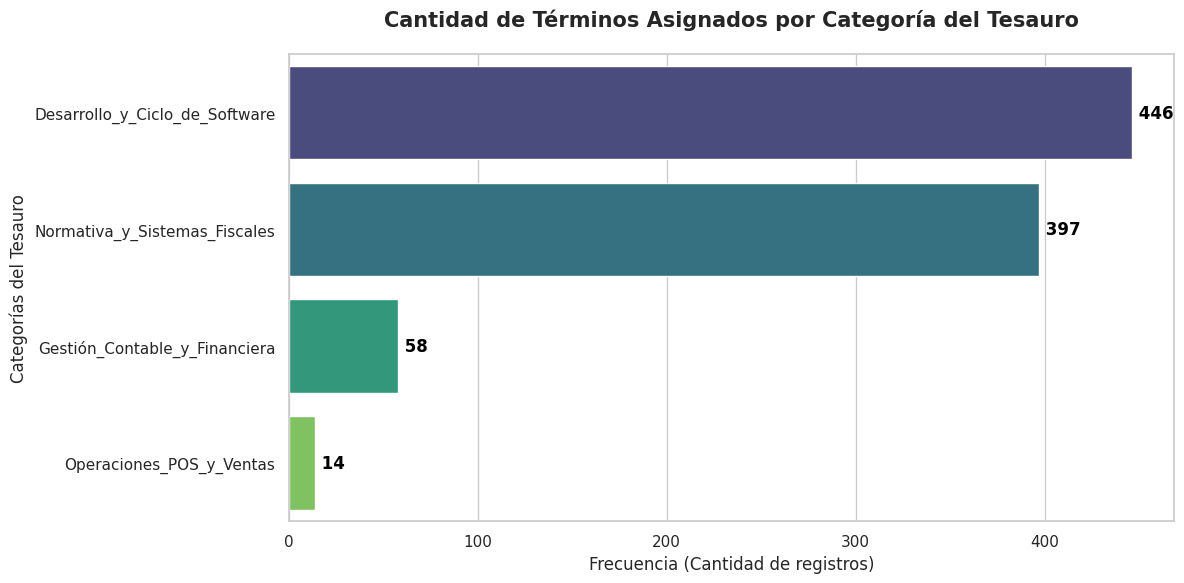

Generando Matriz de Confusión para el modelo Multinomial...


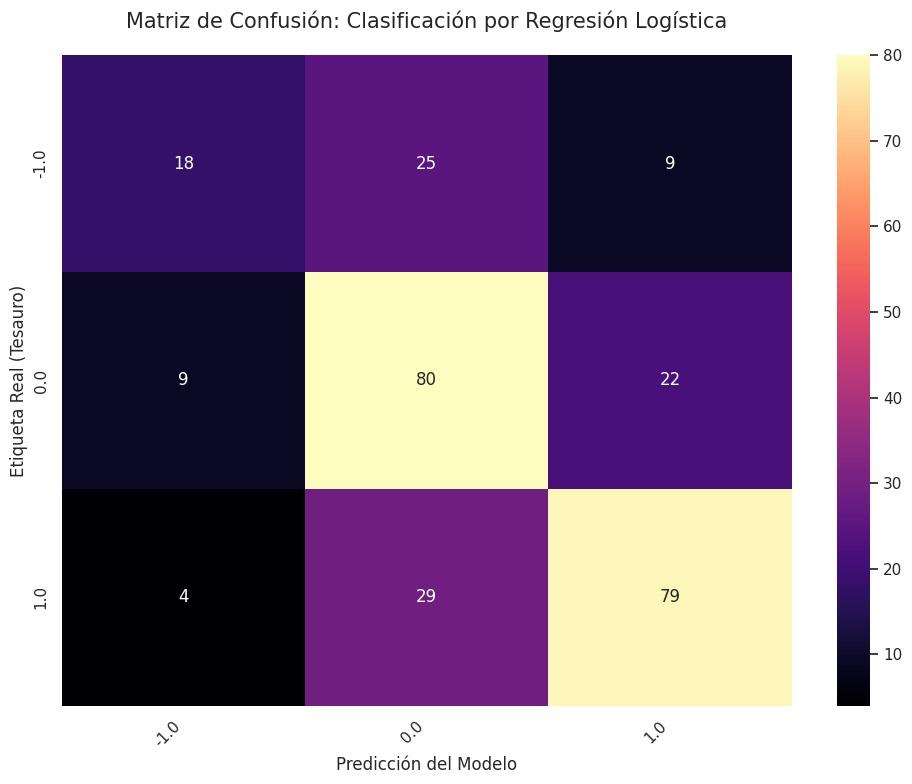

In [54]:

# ==========================================
# 14. GRÁFICOS
# ==========================================

# --- REPRESENTACIÓN DE K-MEANS
sns.set_theme(style="whitegrid", palette="muted")
sns.set_theme(style="whitegrid")
if 'pln_coleccion' in locals() and 'Reetiquetado K-Means' in pln_coleccion.columns:
    counts = pln_coleccion['Reetiquetado K-Means'].value_counts()
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x=counts.values,
        y=counts.index,
        palette='viridis',
        hue=counts.index,
        legend=False
    )
    plt.title("Cantidad de Términos Asignados por Categoría del Tesauro", fontsize=15, fontweight='bold', pad=20)
    plt.xlabel("Frecuencia (Cantidad de registros)", fontsize=12)
    plt.ylabel("Categorías del Tesauro", fontsize=12)
    for i, v in enumerate(counts.values):
        ax.text(v + 0.5, i, f' {int(v)}', color='black', va='center', fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Error: No se encontró la columna 'Reetiquetado K-Means' en el dataframe 'pln_coleccion'.")

# --- MATRIZ DE CONFUSIÓN (REGRESIÓN LOGÍSTICA MULTINOMIAL) ---
if 'y_test' in locals() and 'y_pred' in locals():
    print("Generando Matriz de Confusión para el modelo Multinomial...")
    cm = confusion_matrix(y_test, y_pred)
    clases = sorted(y_test.unique())
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma',
                xticklabels=clases, yticklabels=clases, cbar=True)
    plt.title("Matriz de Confusión: Clasificación por Regresión Logística", fontsize=15, pad=20)
    plt.xlabel("Predicción del Modelo", fontsize=12)
    plt.ylabel("Etiqueta Real (Tesauro)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:

# ==========================================
# 13. REINICIAR CONEXIÓN GTIHUB
# ==========================================

# Configurar la estrategia de reconciliación
!git -C /content/{DEST_REPO_NAME} config pull.rebase false

# Forzar una limpieza y descarga de la versión actual de GitHub
try:
    print("🔄 Sincronizando repositorio...")
    !git -C /content/{DEST_REPO_NAME} fetch origin
    !git -C /content/{DEST_REPO_NAME} reset --hard origin/main
    print("✅ Repositorio sincronizado y limpio.")
except Exception as e:
    print(f"❌ Error al sincronizar: {e}")

🔄 Sincronizando repositorio...
HEAD is now at 55bcf71 Etiqueta Actualizada (2026-02-11 21:44)
✅ Repositorio sincronizado y limpio.
